## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
# Disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], kernel_initializer = 'normal', activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units, kernel_initializer='normal', activation='relu',name="hidden_layer"+str(i+1)))  
        model.add(BatchNormalization())         
    
    model.add(Dense(units=output_units,kernel_initializer='normal', activation='softmax',name='output'))

    return model
    """
    Build your own model
    """

In [6]:
def plot_model_score(results):
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid-'+cond, color=color_bar[i])
   
    plt.title("Loss")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label='valid-'+cond, color=color_bar[i])
   
    plt.title("Accuracy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# 改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCES=[10,30]
FACTORS=[0.3,0.7]

In [10]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
"""
Set model checkpoint callbacks
Write your training loop and show the results
"""
results = {}

for factor,patience in itertools.product(FACTORS,PATIENCES):
    keras.backend.clear_session() 
    # 載入 Callbacks
    reduce_lr = ReduceLROnPlateau(factor=factor,min_lr=1e-12, monitor='val_loss', patience=patience, verbose=1)
    
    model = build_mlp(input_shape=x_train.shape)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reduce_lr]
                  )
   
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'Factor={factor},patience={patience}'
    
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 49/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.8249 - acc: 0.7269 - val_loss: 1.4998 - val_acc: 0.5007
Epoch 50/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.8225 - acc: 0.7281 - val_loss: 1.5010 - val_acc: 0.4989
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024     

Epoch 48/50
50000/50000 [==============================] - 66s 1ms/step - loss: 0.6617 - acc: 0.7875 - val_loss: 1.6075 - val_acc: 0.4832
Epoch 49/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6404 - acc: 0.7962 - val_loss: 1.6246 - val_acc: 0.4877
Epoch 50/50
50000/50000 [==============================] - 66s 1ms/step - loss: 0.6214 - acc: 0.8043 - val_loss: 1.6382 - val_acc: 0.4849
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131

50000/50000 [==============================] - 65s 1ms/step - loss: 0.7589 - acc: 0.7510 - val_loss: 1.5508 - val_acc: 0.4855

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epoch 47/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.7414 - acc: 0.7594 - val_loss: 1.5555 - val_acc: 0.4877
Epoch 48/50
50000/50000 [==============================] - 72s 1ms/step - loss: 0.7277 - acc: 0.7643 - val_loss: 1.5645 - val_acc: 0.4928
Epoch 49/50
50000/50000 [==============================] - 66s 1ms/step - loss: 0.7185 - acc: 0.7684 - val_loss: 1.5673 - val_acc: 0.4900
Epoch 50/50
50000/50000 [==============================] - 64s 1ms/step - loss: 0.7078 - acc: 0.7738 - val_loss: 1.5665 - val_acc: 0.4878
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
___________________________________________

50000/50000 [==============================] - 64s 1ms/step - loss: 0.7440 - acc: 0.7580 - val_loss: 1.5168 - val_acc: 0.4988
Epoch 45/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.7248 - acc: 0.7657 - val_loss: 1.5319 - val_acc: 0.4941
Epoch 46/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.7029 - acc: 0.7756 - val_loss: 1.5387 - val_acc: 0.4976
Epoch 47/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6839 - acc: 0.7822 - val_loss: 1.5564 - val_acc: 0.4919
Epoch 48/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6637 - acc: 0.7907 - val_loss: 1.5661 - val_acc: 0.4988
Epoch 49/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6450 - acc: 0.7968 - val_loss: 1.5736 - val_acc: 0.4970
Epoch 50/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6263 - acc: 0.8057 - val_loss: 1.5845 - val_acc: 0.4967


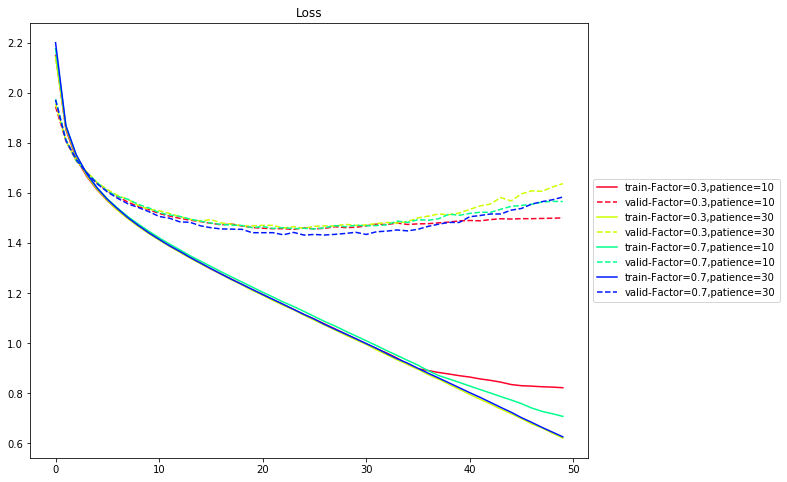

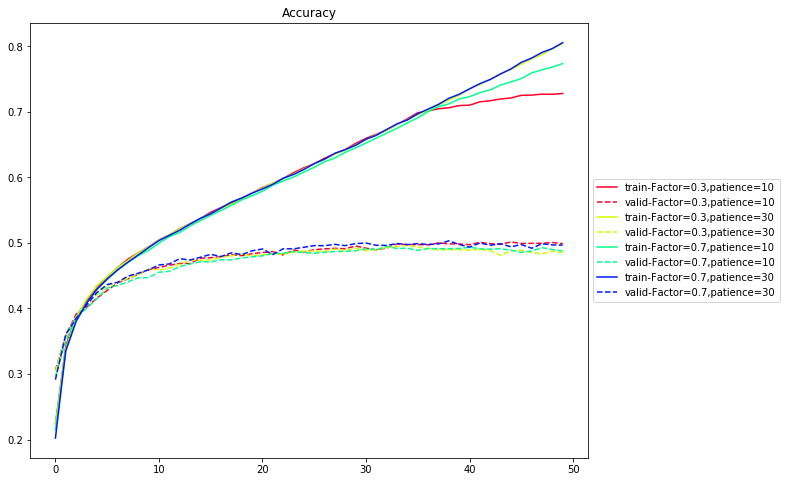

In [11]:
# 繪製結果
"""
plot the results
"""
plot_model_score(results)

# 將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [13]:
Sgd = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
RMSprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

optimizers = ['Sgd','Adam','RMSprop']

In [14]:
results = {}

for  optimizer in optimizers:
    keras.backend.clear_session() 
    # 載入 Callbacks
    reduce_lr = ReduceLROnPlateau(factor=0.5,min_lr=1e-12, monitor='val_loss', patience=5, verbose=1)
    
    model = build_mlp(input_shape=x_train.shape)
    model.summary()
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reduce_lr]
                  )
   
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'Optimizer={optimizer}'
    
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 64s 1ms/step - loss: 1.0486 - acc: 0.6392 - val_loss: 1.4763 - val_acc: 0.4872

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
________________________________________________________

50000/50000 [==============================] - 69s 1ms/step - loss: 0.2651 - acc: 0.9439 - val_loss: 1.6137 - val_acc: 0.5378
Epoch 45/50
50000/50000 [==============================] - 69s 1ms/step - loss: 0.2634 - acc: 0.9443 - val_loss: 1.6185 - val_acc: 0.5374
Epoch 46/50
50000/50000 [==============================] - 69s 1ms/step - loss: 0.2623 - acc: 0.9447 - val_loss: 1.6210 - val_acc: 0.5377
Epoch 47/50
50000/50000 [==============================] - 70s 1ms/step - loss: 0.2611 - acc: 0.9456 - val_loss: 1.6232 - val_acc: 0.5374
Epoch 48/50
50000/50000 [==============================] - 69s 1ms/step - loss: 0.2593 - acc: 0.9466 - val_loss: 1.6221 - val_acc: 0.5363

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 49/50
50000/50000 [==============================] - 69s 1ms/step - loss: 0.2579 - acc: 0.9465 - val_loss: 1.6239 - val_acc: 0.5379
Epoch 50/50
50000/50000 [==============================] - 70s 1ms/step - loss: 0.2571 - acc: 0.9472 - 

50000/50000 [==============================] - 67s 1ms/step - loss: 0.3868 - acc: 0.8908 - val_loss: 1.5436 - val_acc: 0.5424
Epoch 41/50
50000/50000 [==============================] - 69s 1ms/step - loss: 0.3808 - acc: 0.8935 - val_loss: 1.5591 - val_acc: 0.5416
Epoch 42/50
50000/50000 [==============================] - 67s 1ms/step - loss: 0.3775 - acc: 0.8943 - val_loss: 1.5639 - val_acc: 0.5390
Epoch 43/50
50000/50000 [==============================] - 68s 1ms/step - loss: 0.3719 - acc: 0.8970 - val_loss: 1.5621 - val_acc: 0.5396
Epoch 44/50
50000/50000 [==============================] - 67s 1ms/step - loss: 0.3679 - acc: 0.8988 - val_loss: 1.5689 - val_acc: 0.5400

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 45/50
50000/50000 [==============================] - 67s 1ms/step - loss: 0.3591 - acc: 0.9035 - val_loss: 1.5681 - val_acc: 0.5415
Epoch 46/50
50000/50000 [==============================] - 67s 1ms/step - loss: 0.3567 - acc: 0.9038 -

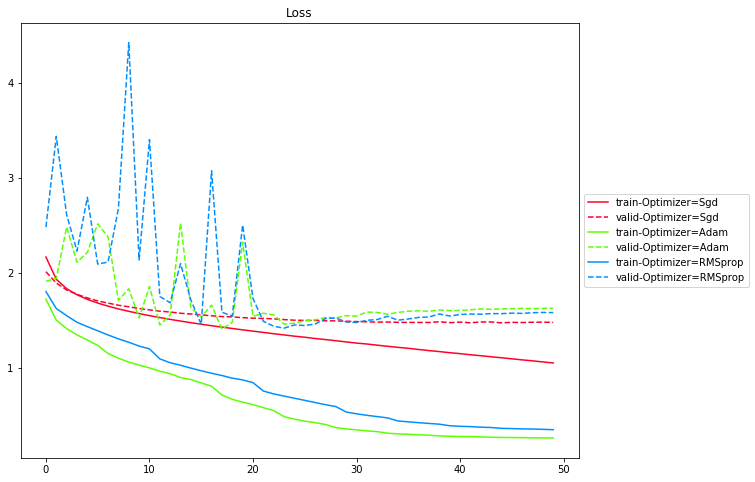

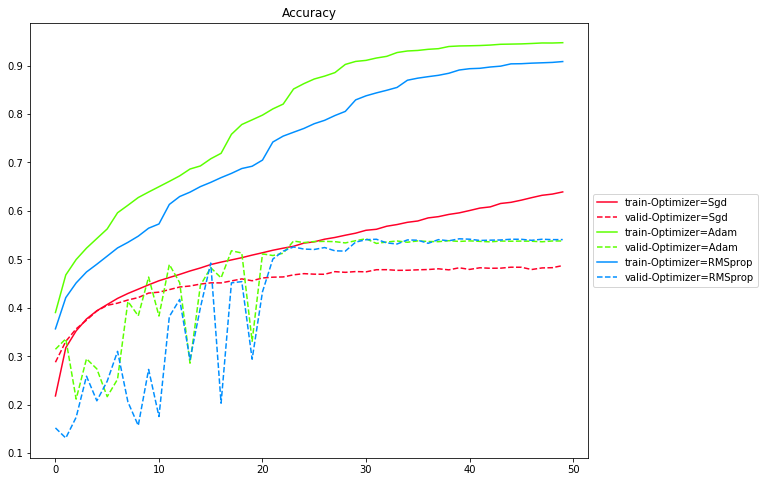

In [15]:
plot_model_score(results)